<a href="https://colab.research.google.com/github/xDaryamo/NFR-Security-Extraction-Classification/blob/master/NFR_Classification_Categorization_Tfidf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0) Dipendenze e utils


##0.1 Dipendenze

In [1]:
!python -m spacy download en_core_web_trf --quiet
!pip install spacy-transformers --quiet

2022-11-28 16:43:28.657201: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
     |████████████████████████████████| 460.3 MB 21 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


In [2]:
!pip install scikit-plot --quiet
!pip install scikit-multilearn --quiet

In [3]:
import pandas as pd
import spacy
from spacy import displacy
from tabulate import tabulate
from string import punctuation
import re
import spacy_transformers
import numpy as np
from numpy import mean
import ast
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score, plot_confusion_matrix, balanced_accuracy_score, hamming_loss, f1_score, multilabel_confusion_matrix,ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.model_selection import RepeatedKFold, KFold,StratifiedKFold,RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict, GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.preprocessing import MultiLabelBinarizer
import skmultilearn
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset
import warnings



In [4]:
nlp = spacy.load("en_core_web_trf")

##0.2) Funzioni utili

In [5]:
all_entities = list(nlp.get_pipe("ner").labels)
all_pos = ['ADJ','ADP','ADV','AUX','CONJ','CCONJ','DET','INTJ','NOUN','NUM','PART','PRON','PROPN','PUNCT','SCONJ','SYM','VERB','X','SPACE']
all_dep = list(nlp.get_pipe("parser").labels)

In [6]:
def str_to_list(ent, dep, pos):
  if not isinstance(ent, list):
    ent = ast.literal_eval(ent)
    ent = [n.strip() for n in ent]
  if not isinstance(dep, list):
    dep = ast.literal_eval(dep)
    dep = [n.strip() for n in dep]
  if not isinstance(pos, list):
    pos = ast.literal_eval(pos)
    pos = [n.strip() for n in pos]

  return ent, dep, pos

In [7]:
def conc_3_lists(a,b,c):
  temp = np.concatenate((a, b), axis=0)
  result = np.concatenate((temp, c), axis=0)
  return " ".join(result.tolist())


In [8]:
def extract_features(ent, dep, pos):
  ent, dep, pos = str_to_list(ent,dep,pos)
  return conc_3_lists(ent, dep, pos)

#1) Classificatore Binario

## 1.1) Ottenimento del Dataset

In [9]:
root="https://raw.githubusercontent.com/xDaryamo/NFR-Security-Extraction-Classification/master/"


#df è la variabile che contiene il dataset
df=pd.read_excel(root + "dataset.xlsx")

df=df[["Sentence","Entities", "Dependencies", "Parts of Speech", "Categories", "Security Words", "Security"]]
df.head(5)


,Sentence,Entities,Dependencies,Parts of Speech,Categories,Security Words,Security
0,The vision of healthier Canadians through inno...,"['The', 'vision', 'of', 'healthier', 'NORP', '...","['det', 'nsubjpass', 'prep', 'amod', 'pobj', '...","['DET', 'NOUN', 'ADP', 'ADJ', 'PROPN', 'ADP', ...","['CONFIDENTIALITY', 'AVAILABILITY', 'INTEGRITY']",['access'],1
1,"Once completed, the electronic health record (...","['Once', 'completed', 'the', 'electronic', 'he...","['advmod', 'advcl', 'det', 'amod', 'compound',...","['ADV', 'VERB', 'DET', 'ADJ', 'NOUN', 'NOUN', ...",none,none,0
2,Canada Health Infoway's (Infoway's) Nursing Re...,"['ORG', 'ORG', 'ORG', 'ORG', 'ORG', ""'s"", 'ORG...","['compound', 'compound', 'poss', 'case', 'poss...","['PROPN', 'PROPN', 'PROPN', 'PART', 'PROPN', '...",none,none,0
3,Timely access to information will help inform ...,"['Timely', 'access', 'to', 'information', 'wil...","['amod', 'nsubj', 'prep', 'pobj', 'aux', 'ROOT...","['ADJ', 'NOUN', 'ADP', 'NOUN', 'AUX', 'VERB', ...",['AVAILABILITY'],['access'],1
4,"As part of the NRG, a pan-Canadian working gro...","['As', 'part', 'of', 'the', 'ORG', 'a', 'NORP'...","['prep', 'pobj', 'prep', 'det', 'pobj', 'det',...","['ADP', 'NOUN', 'ADP', 'DET', 'PROPN', 'DET', ...",none,none,0


##1.2) Codifica delle features

In [10]:
sec_df=pd.DataFrame(columns=["Entities", "Dependencies", "Parts of Speech", "Text", "Security Words", "Security"])

for i in range(0, len(df)):
  ent, dep, pos = df.iloc[i]["Entities"], df.iloc[i]["Dependencies"], df.iloc[i]["Parts of Speech"]
  sec_df.loc[i, "Entities"] = ent
  sec_df.loc[i, "Dependencies"] = dep
  sec_df.loc[i, "Parts of Speech"] = pos
  sec_df.loc[i, "Text"] = extract_features(ent,dep,pos)
  sec_df.loc[i, "Security Words"] = df.iloc[i]["Security Words"]
  sec_df.loc[i, "Security"] = df.iloc[i]["Security"]

sec_df.head()

,Entities,Dependencies,Parts of Speech,Text,Security Words,Security
0,"['The', 'vision', 'of', 'healthier', 'NORP', '...","['det', 'nsubjpass', 'prep', 'amod', 'pobj', '...","['DET', 'NOUN', 'ADP', 'ADJ', 'PROPN', 'ADP', ...",The vision of healthier NORP through innovativ...,['access'],1
1,"['Once', 'completed', 'the', 'electronic', 'he...","['advmod', 'advcl', 'det', 'amod', 'compound',...","['ADV', 'VERB', 'DET', 'ADJ', 'NOUN', 'NOUN', ...",Once completed the electronic health record EH...,none,0
2,"['ORG', 'ORG', 'ORG', 'ORG', 'ORG', ""'s"", 'ORG...","['compound', 'compound', 'poss', 'case', 'poss...","['PROPN', 'PROPN', 'PROPN', 'PART', 'PROPN', '...",ORG ORG ORG ORG ORG 's ORG ORG ORG ORG recogni...,none,0
3,"['Timely', 'access', 'to', 'information', 'wil...","['amod', 'nsubj', 'prep', 'pobj', 'aux', 'ROOT...","['ADJ', 'NOUN', 'ADP', 'NOUN', 'AUX', 'VERB', ...",Timely access to information will help inform ...,['access'],1
4,"['As', 'part', 'of', 'the', 'ORG', 'a', 'NORP'...","['prep', 'pobj', 'prep', 'det', 'pobj', 'det',...","['ADP', 'NOUN', 'ADP', 'DET', 'PROPN', 'DET', ...",As part of the ORG a NORP NORP working group w...,none,0


In [11]:
vocabulary = [*all_entities, *all_dep, *all_pos]

for sentence in sec_df["Text"]:
  for word in sentence.split(" "):
    if word not in vocabulary:
      vocabulary.append(word)

len(vocabulary)

7048

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfVectorizer(analyzer='word', max_features=10000, vocabulary=vocabulary, lowercase=False)

X = tfidf.fit_transform(sec_df['Text']).toarray()
y = sec_df['Security']
y = y.astype('int')
print(X.shape)
print(y.shape)


(5980, 7048)
(5980,)


##1.3) Tuning degli iperparametri


In [13]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
warnings.filterwarnings("ignore")

###1.3.1) Tuning RandomForest

In [57]:
rf = RandomForestClassifier() 

n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points


rf_grid = {
            'n_estimators': n_estimators,
            'max_features': max_features,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'bootstrap': bootstrap
          }

rf_model = RandomizedSearchCV(estimator = rf, param_distributions=rf_grid, n_iter=10, cv=cv, verbose=2,random_state=35, n_jobs = -1)
rf_model.fit(X, y)

rf_best = rf_model.best_params_
print('Config: %s' % rf_best)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Config: {'n_estimators': 16, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}


###1.3.2) Tuning LogisticRegression

In [58]:
lr = LogisticRegression()

lr_grid = [
            {
              'solver' : ['saga'],
              'penalty' : ['elasticnet', 'l1', 'l2', 'none'],
              'max_iter' : [100, 250, 500],
              'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
            {
              'solver' : ['newton-cg', 'lbfgs'],
              'penalty' : ['l2','none'],
              'max_iter' :[100, 250, 500],
              'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
          ]

lr_model = RandomizedSearchCV(estimator = lr, param_distributions=lr_grid, n_iter=10, cv=cv, verbose=2,random_state=35, n_jobs = -1)
lr_model.fit(X, y)

lr_best = lr_model.best_params_
print('Config: %s' % lr_best)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Config: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 500, 'C': 10}


###1.3.3) Tuning SVM

In [59]:
svm = SVC()

svm_grid =  {
              'C': [0.1,1, 10, 100, 1000], 
              'gamma': [1,0.1,0.01,0.001, 0.0001],
              'kernel': ['rbf', 'poly', 'sigmoid']
            }

svm_model = RandomizedSearchCV(estimator = svm, param_distributions=svm_grid, n_iter=10, cv=cv, verbose=2,random_state=35, n_jobs = -1)
svm_model.fit(X, y)

svm_best = svm_model.best_params_
print('Config: %s' % svm_best)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Config: {'kernel': 'poly', 'gamma': 1, 'C': 100}


###1.3.4) Tuning GaussianNB

In [60]:
gNB = GaussianNB()

nb_grid = {
            'var_smoothing': np.logspace(0,-9, num=100)
          }       

nb_model = RandomizedSearchCV(estimator = gNB, param_distributions=nb_grid, n_iter=10, cv=cv, verbose=2,random_state=35, n_jobs = -1)
nb_model.fit(X, y)

nb_best = nb_model.best_params_
print('Config: %s' % nb_best)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Config: {'var_smoothing': 0.006579332246575682}


###1.3.5) Tuning KNN

In [61]:
knn = KNeighborsClassifier(algorithm='auto')


knn_grid =  {
              'n_neighbors': (1,10, 1),
              'leaf_size': (20,40,1),
              'p': (1,2),
              'weights': ('uniform', 'distance'),
              'metric': ('minkowski', 'chebyshev'),
            }       

knn_model = RandomizedSearchCV(estimator = knn, param_distributions=knn_grid, n_iter=10, cv=cv, verbose=2,random_state=35, n_jobs = -1)
knn_model.fit(X, y)

knn_best = knn_model.best_params_
print('Config: %s' % knn_best)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Config: {'weights': 'distance', 'p': 2, 'n_neighbors': 1, 'metric': 'minkowski', 'leaf_size': 1}


###1.3.6) Tuning DecisionTree

In [62]:
dt = DecisionTreeClassifier()


dt_grid = {
            'max_features': ['auto', 'sqrt', 'log2'],
            'ccp_alpha': [0.1, .01, .001],
            'max_depth' : [5, 6, 7, 8, 9],
            'criterion' :['gini', 'entropy']
          }    

dt_model = RandomizedSearchCV(estimator = dt, param_distributions=dt_grid, n_iter=10, cv=cv, verbose=2,random_state=35, n_jobs = -1)
dt_model.fit(X, y)

dt_best = dt_model.best_params_
print('Config: %s' % dt_best)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Config: {'max_features': 'sqrt', 'max_depth': 7, 'criterion': 'entropy', 'ccp_alpha': 0.001}


##1.4) Validazione modelli con Cross-Fold Validation

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X = tfidf.fit_transform(sec_df['Text']).toarray()
y = sec_df['Security']
y = y.astype('int')

print(X.shape)
print(y.shape)

(5980, 7048)
(5980,)


###1.4.1) Logistic regression

fit_time:  8.255931329727172
Accuracy:  0.8481605351170568
F1_macro:  0.8481605351170568
Precision_micro:  0.8481605351170568
Recall_micro:  0.8481605351170568


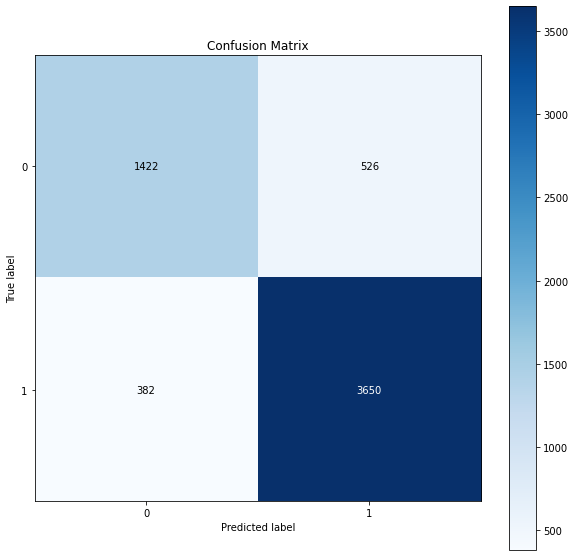

In [64]:
lr = LogisticRegression(solver='newton-cg', penalty='l2', max_iter= 500, C=10)
scoring = {'accuracy': 'accuracy',
           'f1': 'f1_micro',
           'precision': 'precision_micro',
           'recall': 'recall_micro'}
lr_scores = cross_validate(lr, X, y, scoring=scoring, cv=cv)
print("fit_time: ",np.mean(lr_scores['fit_time']))
print("Accuracy: ",np.mean(lr_scores['test_accuracy']))
print("F1_macro: ",np.mean(lr_scores['test_f1']))
print("Precision_micro: ",np.mean(lr_scores['test_precision']))
print("Recall_micro: ",np.mean(lr_scores['test_recall']))

predictions = cross_val_predict(lr, X, y,cv=cv)

fig, ax = plt.subplots(figsize=(10, 10))

ax2 = skplt.metrics.plot_confusion_matrix(y, predictions,cmap=plt.cm.Blues, ax=ax)
plt.show()


###1.4.2) RandomForest

fit_time:  1.9348140239715577
Accuracy:  0.7933110367892977
F1_macro:  0.7933110367892977
Precision_micro:  0.7933110367892977
Recall_micro:  0.7933110367892977


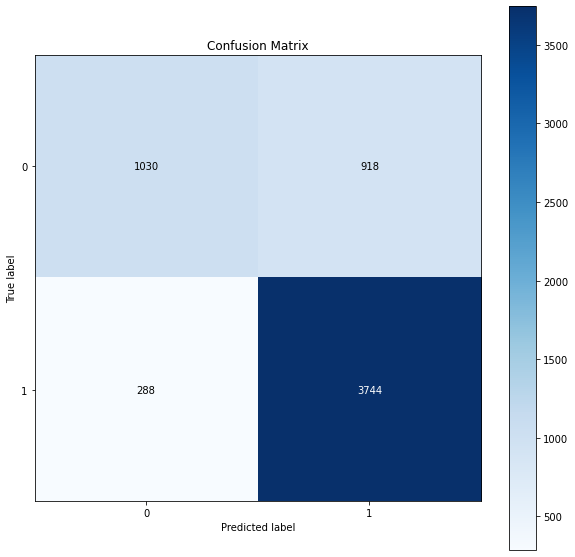

In [65]:
rf = RandomForestClassifier(n_estimators=14, min_samples_split=2, min_samples_leaf=3, max_features='auto', max_depth=50, bootstrap=False)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1_micro',
           'precision': 'precision_micro',
           'recall': 'recall_micro'}

rf_scores = cross_validate(rf, X, y, scoring=scoring, cv=cv)
print("fit_time: ",np.mean(rf_scores['fit_time']))
print("Accuracy: ",np.mean(rf_scores['test_accuracy']))
print("F1_macro: ",np.mean(rf_scores['test_f1']))
print("Precision_micro: ",np.mean(rf_scores['test_precision']))
print("Recall_micro: ",np.mean(rf_scores['test_recall']))

predictions = cross_val_predict(rf, X, y,cv=cv)

fig, ax = plt.subplots(figsize=(10, 10))

ax2 = skplt.metrics.plot_confusion_matrix(y, predictions,cmap=plt.cm.Blues, ax=ax)
plt.show()


###1.4.3) Gaussian Naive Bayes

fit_time:  0.5331486225128174
Accuracy:  0.8093645484949832
F1_micro:  0.8093645484949832
Precision_micro:  0.8093645484949832
Recall_micro:  0.8093645484949832


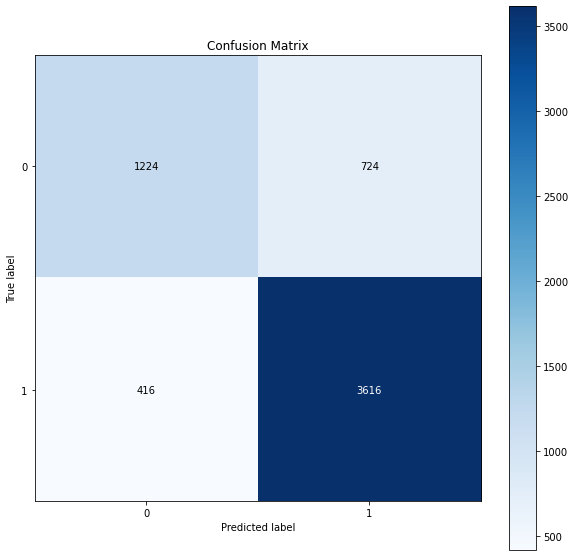

In [66]:
gNB = GaussianNB(var_smoothing=0.006579332246575682)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1_micro',
           'precision': 'precision_micro',
           'recall': 'recall_micro'}
gb_scores = cross_validate(gNB, X, y, scoring=scoring, cv=cv)
print("fit_time: ",np.mean(gb_scores['fit_time']))
print("Accuracy: ",np.mean(gb_scores['test_accuracy']))
print("F1_micro: ",np.mean(gb_scores['test_f1']))
print("Precision_micro: ",np.mean(gb_scores['test_precision']))
print("Recall_micro: ",np.mean(gb_scores['test_recall']))

predictions = cross_val_predict(gNB, X, y,cv=cv)

fig, ax = plt.subplots(figsize=(10, 10))

ax2 = skplt.metrics.plot_confusion_matrix(y, predictions,cmap=plt.cm.Blues, ax=ax)
plt.show()


###1.4.4) Support Vector Machine

fit_time:  121.64859704971313
Accuracy:  0.8568561872909699
F1_micro:  0.8568561872909699
Precision_micro:  0.8568561872909699
Recall_micro:  0.8568561872909699


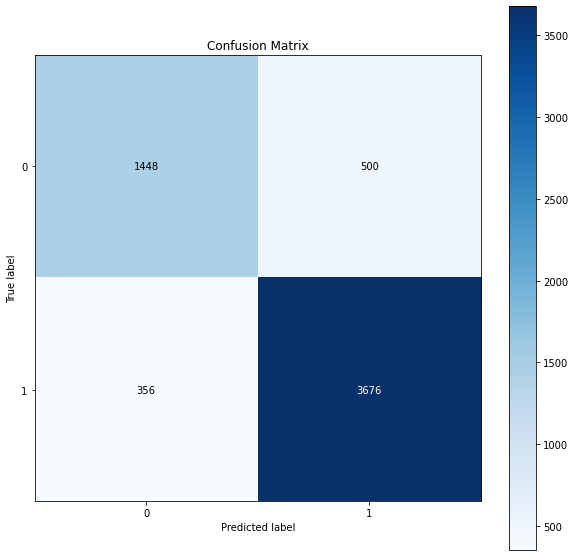

In [67]:
svm = SVC(kernel='poly', gamma=1, C=100)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1_micro',
           'precision': 'precision_micro',
           'recall': 'recall_micro'}
svm_scores = cross_validate(svm, X, y, scoring=scoring, cv=cv)
print("fit_time: ",np.mean(svm_scores['fit_time']))
print("Accuracy: ",np.mean(svm_scores['test_accuracy']))
print("F1_micro: ",np.mean(svm_scores['test_f1']))
print("Precision_micro: ",np.mean(svm_scores['test_precision']))
print("Recall_micro: ",np.mean(svm_scores['test_recall']))

predictions = cross_val_predict(svm, X, y,cv=cv)

fig, ax = plt.subplots(figsize=(10, 10))

ax2 = skplt.metrics.plot_confusion_matrix(y, predictions,cmap=plt.cm.Blues, ax=ax)
plt.show()

###1.4.5) k-Nearest Neighbors

fit_time:  0.10356903076171875
Accuracy:  0.7944816053511705
F1_micro:  0.7944816053511705
Precision_micro:  0.7944816053511705
Recall_micro:  0.7944816053511705


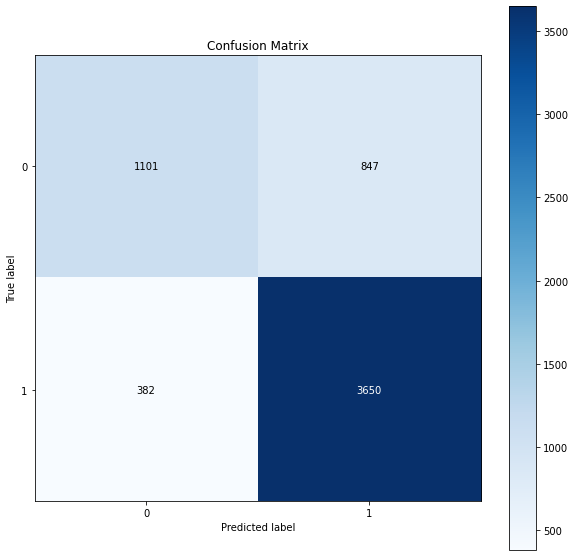

In [68]:
knn = KNeighborsClassifier(algorithm='auto',weights='distance',p=2,n_neighbors=1, metric='minkowski', leaf_size=1)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1_micro',
           'precision': 'precision_micro',
           'recall': 'recall_micro'}
knn_scores = cross_validate(knn, X, y, scoring=scoring, cv=cv)
print("fit_time: ",np.mean(knn_scores['fit_time']))
print("Accuracy: ",np.mean(knn_scores['test_accuracy']))
print("F1_micro: ",np.mean(knn_scores['test_f1']))
print("Precision_micro: ",np.mean(knn_scores['test_precision']))
print("Recall_micro: ",np.mean(knn_scores['test_recall']))

predictions = cross_val_predict(knn, X, y,cv=cv)

fig, ax = plt.subplots(figsize=(10, 10))

ax2 = skplt.metrics.plot_confusion_matrix(y, predictions,cmap=plt.cm.Blues, ax=ax)
plt.show()


###1.4.6) Decision Tree

fit_time:  0.15508074760437013
Accuracy:  0.6770903010033444
F1_micro:  0.6770903010033444
Precision_micro:  0.6770903010033444
Recall_micro:  0.6770903010033444


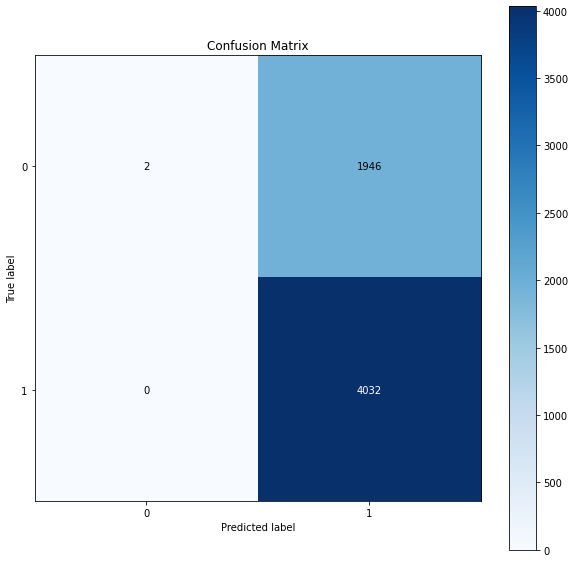

In [69]:
dt = DecisionTreeClassifier(max_features='log2',max_depth=6,criterion='gini',ccp_alpha=0.001)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1_micro',
           'precision': 'precision_micro',
           'recall': 'recall_micro'}
dt_scores = cross_validate(dt, X, y, scoring=scoring, cv=cv)
print("fit_time: ",np.mean(dt_scores['fit_time']))
print("Accuracy: ",np.mean(dt_scores['test_accuracy']))
print("F1_micro: ",np.mean(dt_scores['test_f1']))
print("Precision_micro: ",np.mean(dt_scores['test_precision']))
print("Recall_micro: ",np.mean(dt_scores['test_recall']))

predictions = cross_val_predict(dt, X, y,cv=cv)

fig, ax = plt.subplots(figsize=(10, 10))

ax2 = skplt.metrics.plot_confusion_matrix(y, predictions,cmap=plt.cm.Blues, ax=ax)
plt.show()


#2) Classificatore Multi-label

##2.1) Ottenimento del Dataset

In [15]:
root="https://raw.githubusercontent.com/xDaryamo/NFR-Security-Extraction-Classification/master/"


#df è la variabile che contiene il dataset
df=pd.read_excel(root + "dataset.xlsx")
df=df[["Sentence","Entities", "Dependencies", "Parts of Speech", "Categories", "Security Words", "Security"]]
df.head(5)

,Sentence,Entities,Dependencies,Parts of Speech,Categories,Security Words,Security
0,The vision of healthier Canadians through inno...,"['The', 'vision', 'of', 'healthier', 'NORP', '...","['det', 'nsubjpass', 'prep', 'amod', 'pobj', '...","['DET', 'NOUN', 'ADP', 'ADJ', 'PROPN', 'ADP', ...","['CONFIDENTIALITY', 'AVAILABILITY', 'INTEGRITY']",['access'],1
1,"Once completed, the electronic health record (...","['Once', 'completed', 'the', 'electronic', 'he...","['advmod', 'advcl', 'det', 'amod', 'compound',...","['ADV', 'VERB', 'DET', 'ADJ', 'NOUN', 'NOUN', ...",none,none,0
2,Canada Health Infoway's (Infoway's) Nursing Re...,"['ORG', 'ORG', 'ORG', 'ORG', 'ORG', ""'s"", 'ORG...","['compound', 'compound', 'poss', 'case', 'poss...","['PROPN', 'PROPN', 'PROPN', 'PART', 'PROPN', '...",none,none,0
3,Timely access to information will help inform ...,"['Timely', 'access', 'to', 'information', 'wil...","['amod', 'nsubj', 'prep', 'pobj', 'aux', 'ROOT...","['ADJ', 'NOUN', 'ADP', 'NOUN', 'AUX', 'VERB', ...",['AVAILABILITY'],['access'],1
4,"As part of the NRG, a pan-Canadian working gro...","['As', 'part', 'of', 'the', 'ORG', 'a', 'NORP'...","['prep', 'pobj', 'prep', 'det', 'pobj', 'det',...","['ADP', 'NOUN', 'ADP', 'DET', 'PROPN', 'DET', ...",none,none,0


In [16]:
#Per allenare il modello che si occupa di categorizzare i requisiti dobbiamo eliminare tutte le righe che non contengono un requisito di sicurezza (non hanno categorie associate)

df.drop(df[df.Security == 0.0].index, inplace=True)
df = df.reset_index()  # make sure indexes pair with number of rows
df.head()

,index,Sentence,Entities,Dependencies,Parts of Speech,Categories,Security Words,Security
0,0,The vision of healthier Canadians through inno...,"['The', 'vision', 'of', 'healthier', 'NORP', '...","['det', 'nsubjpass', 'prep', 'amod', 'pobj', '...","['DET', 'NOUN', 'ADP', 'ADJ', 'PROPN', 'ADP', ...","['CONFIDENTIALITY', 'AVAILABILITY', 'INTEGRITY']",['access'],1
1,3,Timely access to information will help inform ...,"['Timely', 'access', 'to', 'information', 'wil...","['amod', 'nsubj', 'prep', 'pobj', 'aux', 'ROOT...","['ADJ', 'NOUN', 'ADP', 'NOUN', 'AUX', 'VERB', ...",['AVAILABILITY'],['access'],1
2,5,It was acknowledged that the EHR needs to enab...,"['It', 'was', 'acknowledged', 'that', 'the', '...","['nsubjpass', 'auxpass', 'ROOT', 'mark', 'det'...","['PRON', 'AUX', 'VERB', 'SCONJ', 'DET', 'PROPN...",['CONFIDENTIALITY'],none,1
3,14,Nursing data: Should be structured and codifie...,"['Nursing', 'data', 'Should', 'be', 'structure...","['compound', 'nsubjpass', 'aux', 'auxpass', 'R...","['NOUN', 'NOUN', 'AUX', 'AUX', 'VERB', 'CCONJ'...",['INTEGRITY'],none,1
4,17,Nursing data: Should be simple and concise to ...,"['Nursing', 'data', 'Should', 'be', 'simple', ...","['compound', 'nsubj', 'aux', 'ROOT', 'acomp', ...","['NOUN', 'NOUN', 'AUX', 'AUX', 'ADJ', 'CCONJ',...",['AVAILABILITY'],['access'],1


##2.2) Codifica delle features

In [17]:
cat_df=pd.DataFrame(columns=["Entities", "Dependencies", "Parts of Speech", "Text", "Security Words", "Categories"])



for i in range(0, len(df)):
  ent, dep, pos = str_to_list(df.iloc[i]["Entities"], df.iloc[i]["Dependencies"], df.iloc[i]["Parts of Speech"])
  cat_df.loc[i, "Entities"] = ent
  cat_df.loc[i, "Dependencies"] = dep
  cat_df.loc[i, "Parts of Speech"] = pos
  cat_df.loc[i, "Text"] = extract_features(ent,dep,pos)
  cat_df.loc[i, "Security Words"] = df.iloc[i]["Security Words"]
  cat_df.loc[i, "Categories"] = df.iloc[i]["Categories"]

cat_df.head()
print(cat_df.shape)

(4032, 6)


##2.3) One-hot encoding delle categorie

In [18]:
#convertiamo le categorie in liste
cat_df['Categories'] = cat_df['Categories'].apply(lambda x: ast.literal_eval(x))


In [19]:
multilabel = MultiLabelBinarizer()
y = multilabel.fit_transform(cat_df['Categories'])
pd.DataFrame(y, columns=multilabel.classes_)

,ACCESS_CONTROL_IDENTITY,ACCOUNTABILITY,AVAILABILITY,CONFIDENTIALITY,INTEGRITY,OPERATIONAL,PRIVACY
0,0,0,1,1,1,0,0
1,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
4027,1,0,0,0,0,0,0
4028,0,1,1,1,0,0,0
4029,0,0,0,0,1,0,0
4030,0,0,0,0,1,0,0


In [20]:
from itertools import groupby
from IPython.display import display, HTML
display(HTML(cat_df.Categories.apply(tuple).value_counts().to_frame().to_html()))

,Categories
"(CONFIDENTIALITY, ACCOUNTABILITY, INTEGRITY)",1599
"(ACCOUNTABILITY, INTEGRITY)",421
"(CONFIDENTIALITY, ACCOUNTABILITY)",331
"(CONFIDENTIALITY,)",191
"(INTEGRITY, ACCOUNTABILITY)",140
"(CONFIDENTIALITY, INTEGRITY, ACCOUNTABILITY)",135
"(OPERATIONAL,)",121
"(INTEGRITY,)",120
"(ACCOUNTABILITY,)",120
"(ACCOUNTABILITY, CONFIDENTIALITY)",82


##2.4) Creazione modelli

In [21]:
def hamming_score(y_true, y_pred):
    y_pred = y_pred.toarray()
    y_pred = y_pred.astype(int)
    return (
        (y_true & y_pred).sum(axis=1) / (y_true | y_pred).sum(axis=1)
    ).mean()

In [22]:
def plot_confusion_matrix(cm):
  f, axes = plt.subplots(2, 4, figsize=(25, 15))
  axes = axes.ravel()
  for i in range(7):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g',cmap='Blues')
    disp.ax_.set_title(list(multilabel.classes_)[i])
    disp.im_.colorbar.remove()

  f.delaxes(axes[7])
  plt.subplots_adjust(wspace=0.25, hspace=0.10)
  f.colorbar(disp.im_, ax=axes)
  plt.show()


In [23]:
def build_model(model, mlb_estimator, X, y):

  clf=mlb_estimator(model)
  kf = KFold(n_splits=5, shuffle=True)

  acc_scores = np.zeros(5)
  prec_scores = np.zeros(5)
  rec_scores = np.zeros(5)  
  f_scores = np.zeros(5)
  ham_scores = np.zeros(5)
  conf_matrix = []
  idx = 0

  for index, (train_indices, test_indices) in enumerate(kf.split(X, y)):
    print("Training on fold " + str(index+1) + "/5...")
    # Generate batches from indices
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    clf.fit(X_train, y_train)
    clf_pred = clf.predict(X_test)

    conf_matrix.append(multilabel_confusion_matrix(y_test, clf_pred ))
    acc_scores[idx] = hamming_score(y_test, clf_pred)
    prec_scores[idx] = precision_score(y_test, clf_pred, average='micro')
    rec_scores[idx] = recall_score(y_test, clf_pred, average='micro')
    f_scores[idx] = f1_score(y_test, clf_pred, average='micro')
    ham_scores[idx] = hamming_loss(y_test, clf_pred)
    idx+=1
  return acc_scores, prec_scores, rec_scores, f_scores, ham_scores, conf_matrix

In [24]:
X = tfidf.fit_transform(cat_df['Text']).toarray()
print(X.shape)
print(y.shape)

(4032, 7048)
(4032, 7)


###**2.4.1) BinaryRelevance**

####2.4.1.1) RandomForest

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7253569931420991
Precision: 0.7790466892306469
Recall Score: 0.8907367225216735
F1 Score: 0.831155114237848
Hamming Loss: 0.12368903431380947


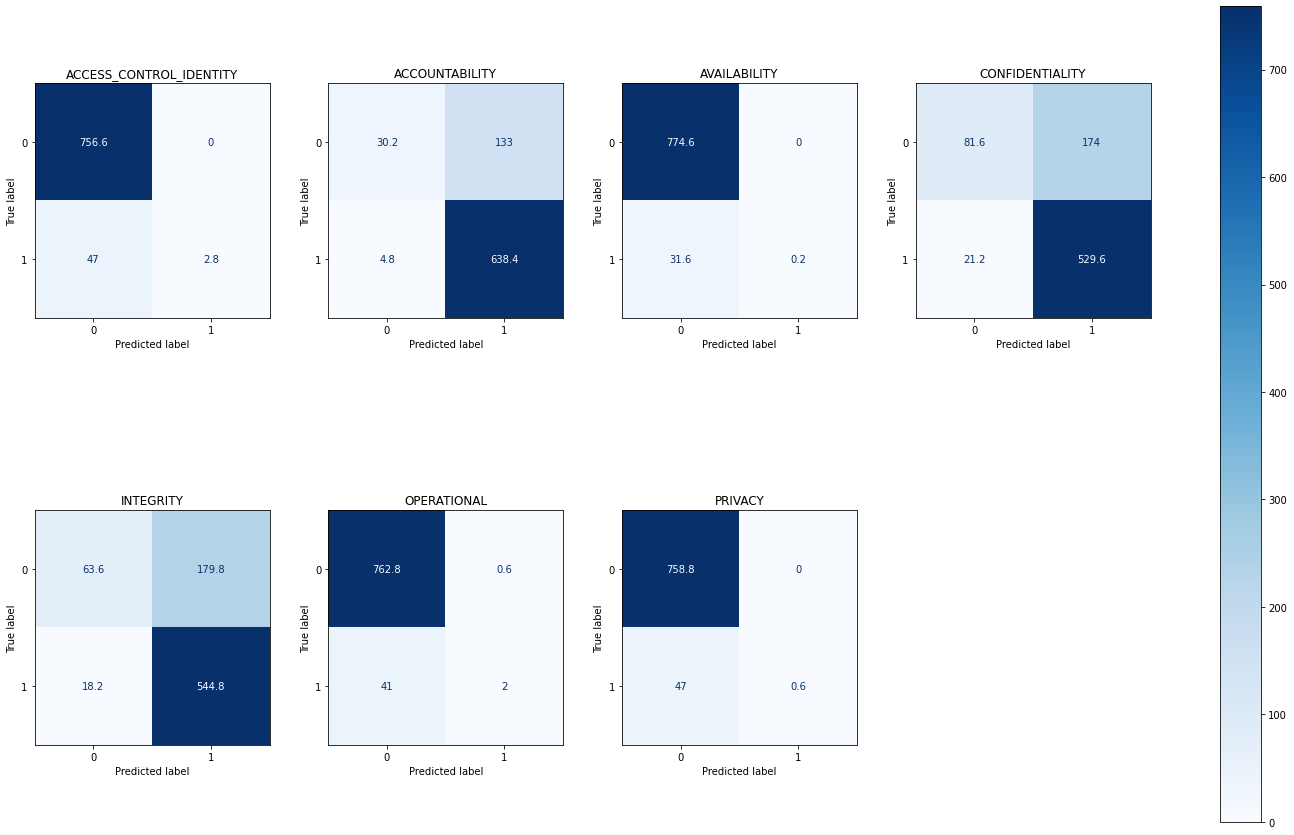

In [42]:
model = RandomForestClassifier(n_estimators=17, min_samples_split=6, min_samples_leaf=4, max_features='sqrt', max_depth=100, bootstrap=False)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, BinaryRelevance, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.1.2) LogisticRegression

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7324835060876553
Precision: 0.8080933800042208
Recall Score: 0.8817644200564901
F1 Score: 0.843300596318468
Hamming Loss: 0.11192463849856822


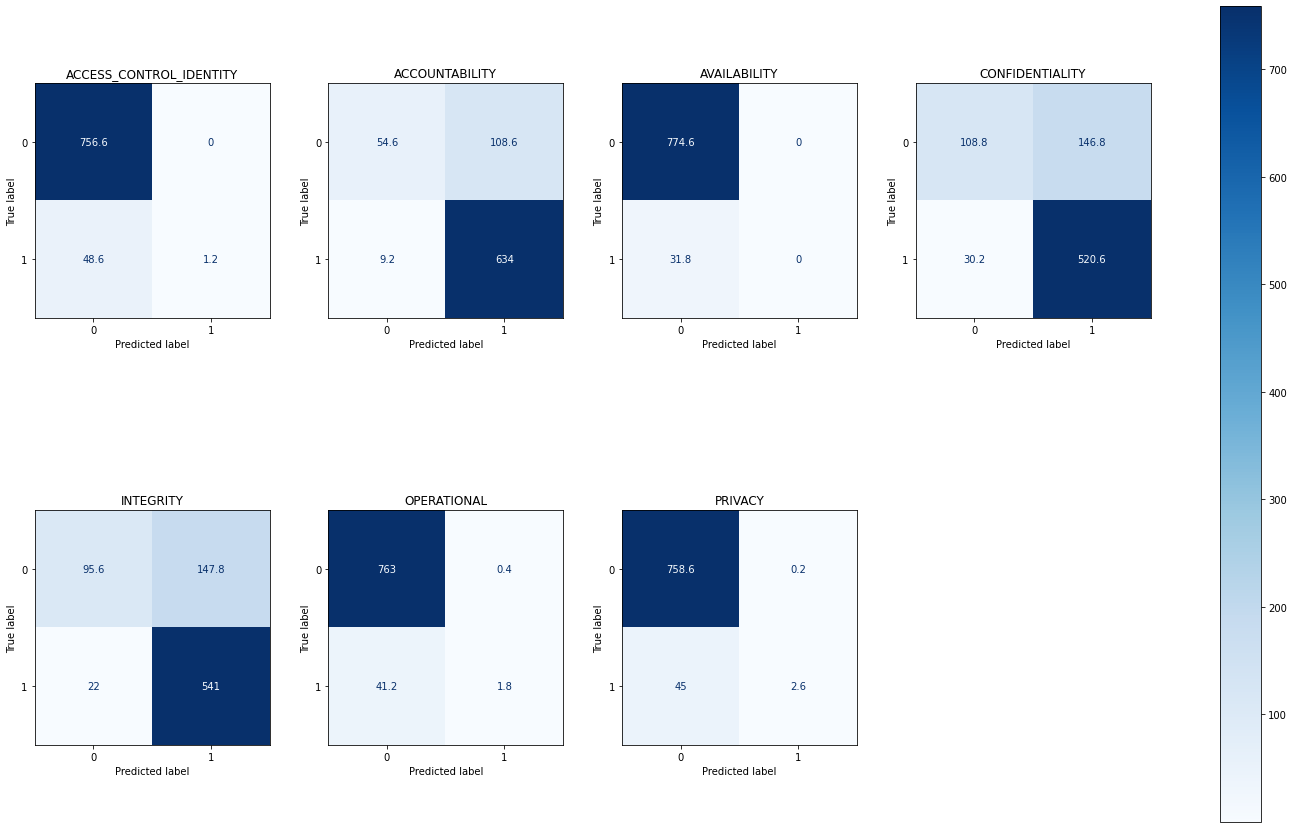

In [43]:
model = LogisticRegression(solver='saga', penalty='l2', max_iter=100, C=1)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, BinaryRelevance, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.1.3) Gaussian Naive Bayes

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7203837544316019
Precision: 0.7352881660896629
Recall Score: 0.92545948387903
F1 Score: 0.8194457092629911
Hamming Loss: 0.1393509556358819


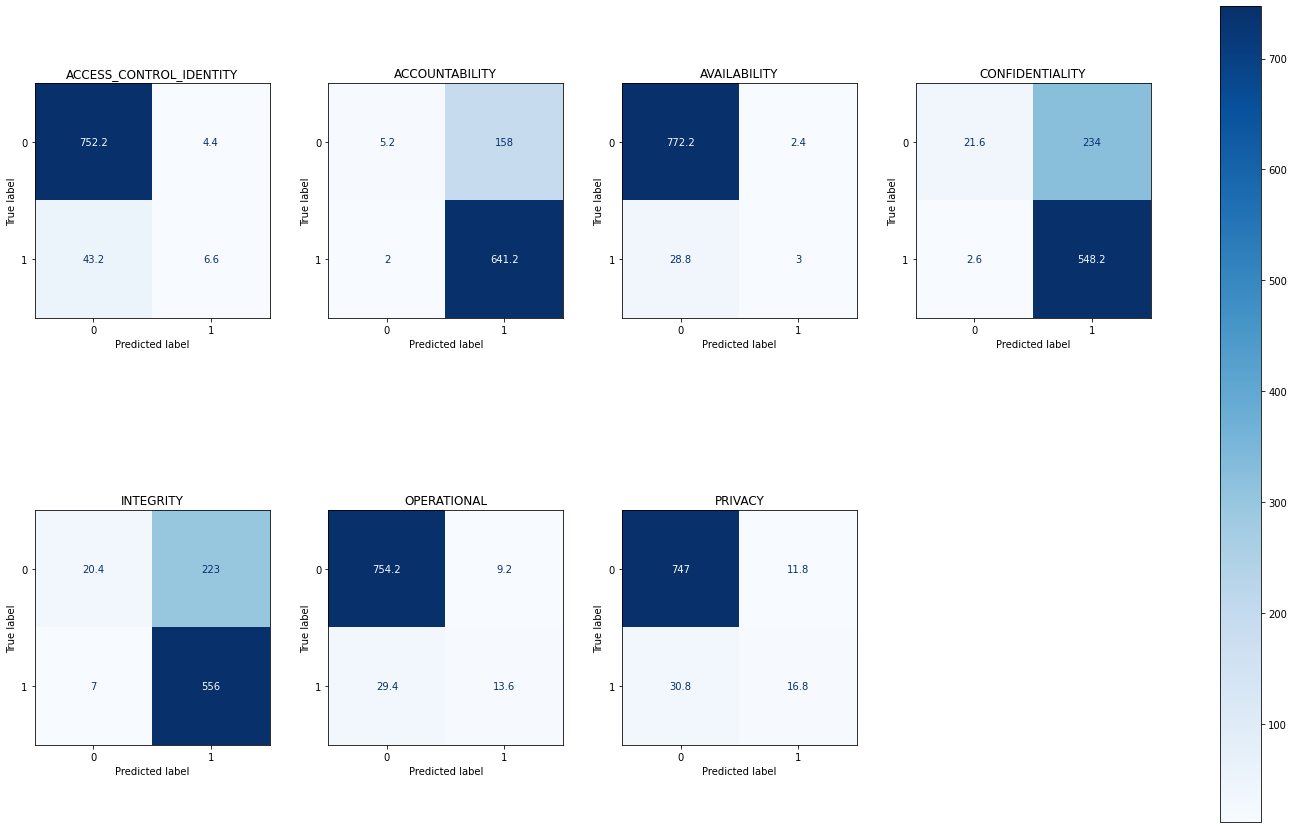

In [44]:
model = GaussianNB(var_smoothing=1.0)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, BinaryRelevance, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.1.4) k-NearestNeighbors

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7308514774056205
Precision: 0.8096546955841053
Recall Score: 0.8590544628400837
F1 Score: 0.8336052804499566
Hamming Loss: 0.11716867694802698


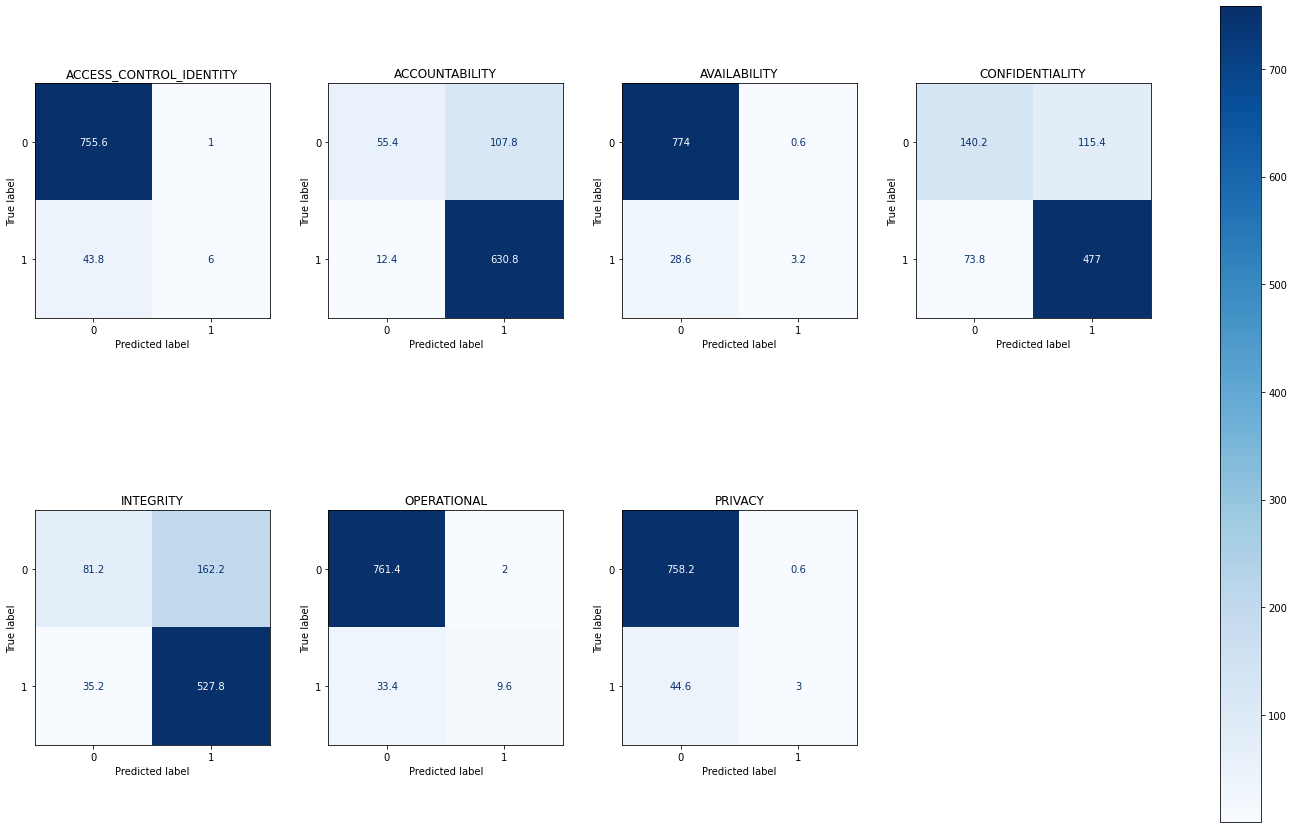

In [45]:
model = KNeighborsClassifier(algorithm='auto', weights='distance', p=1, n_neighbors=10, metric='minkowski', leaf_size=40)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, BinaryRelevance, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.1.5) Decision Tree

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7031221743573344
Precision: 0.7319543712461277
Recall Score: 0.9011926949625542
F1 Score: 0.8077424905342943
Hamming Loss: 0.14657716269420312


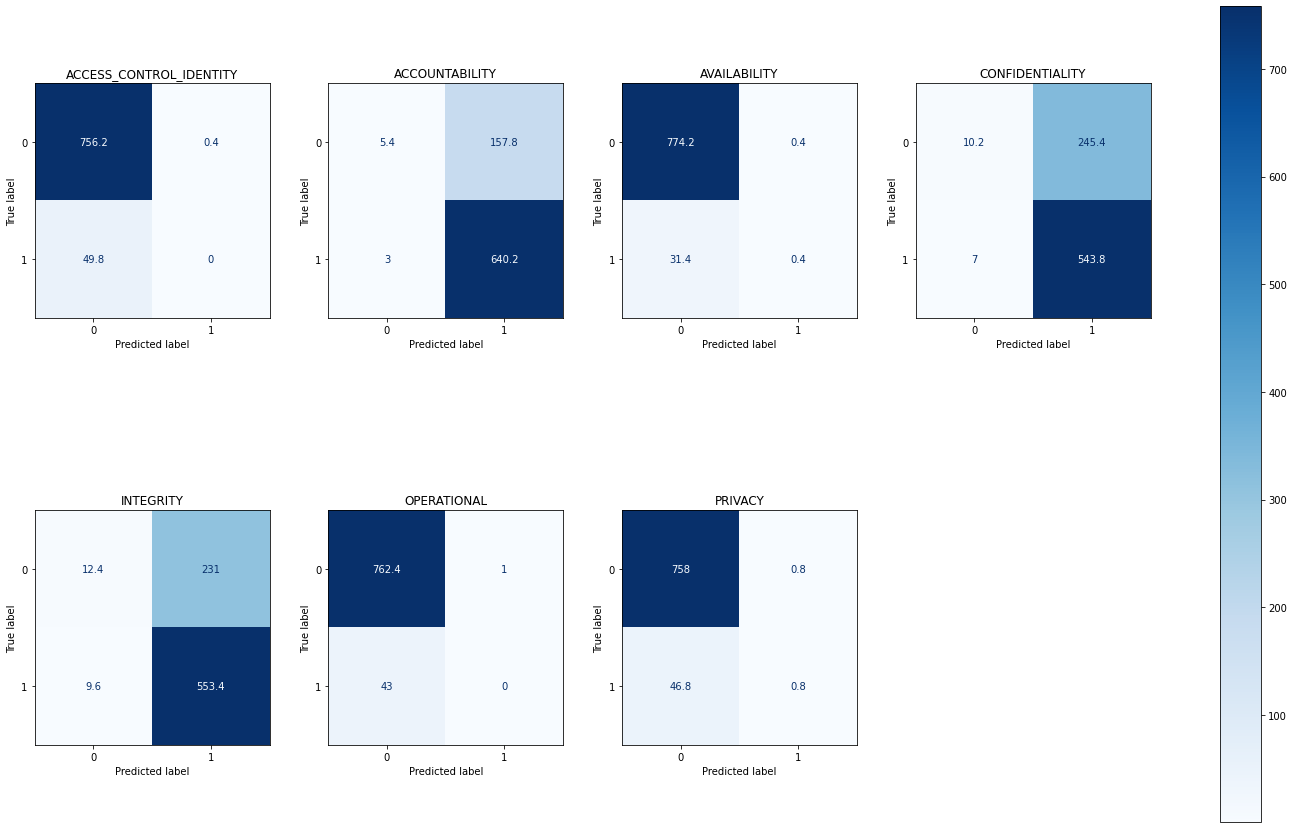

In [46]:
model = DecisionTreeClassifier(max_features='log2', max_depth=8, criterion='entropy', ccp_alpha=0.001)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, BinaryRelevance, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.1.6) Support Vector Machine

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7054164552719534
Precision: 0.7262718787122193
Recall Score: 0.9107665301179433
F1 Score: 0.808117779789356
Hamming Loss: 0.14781904348998726


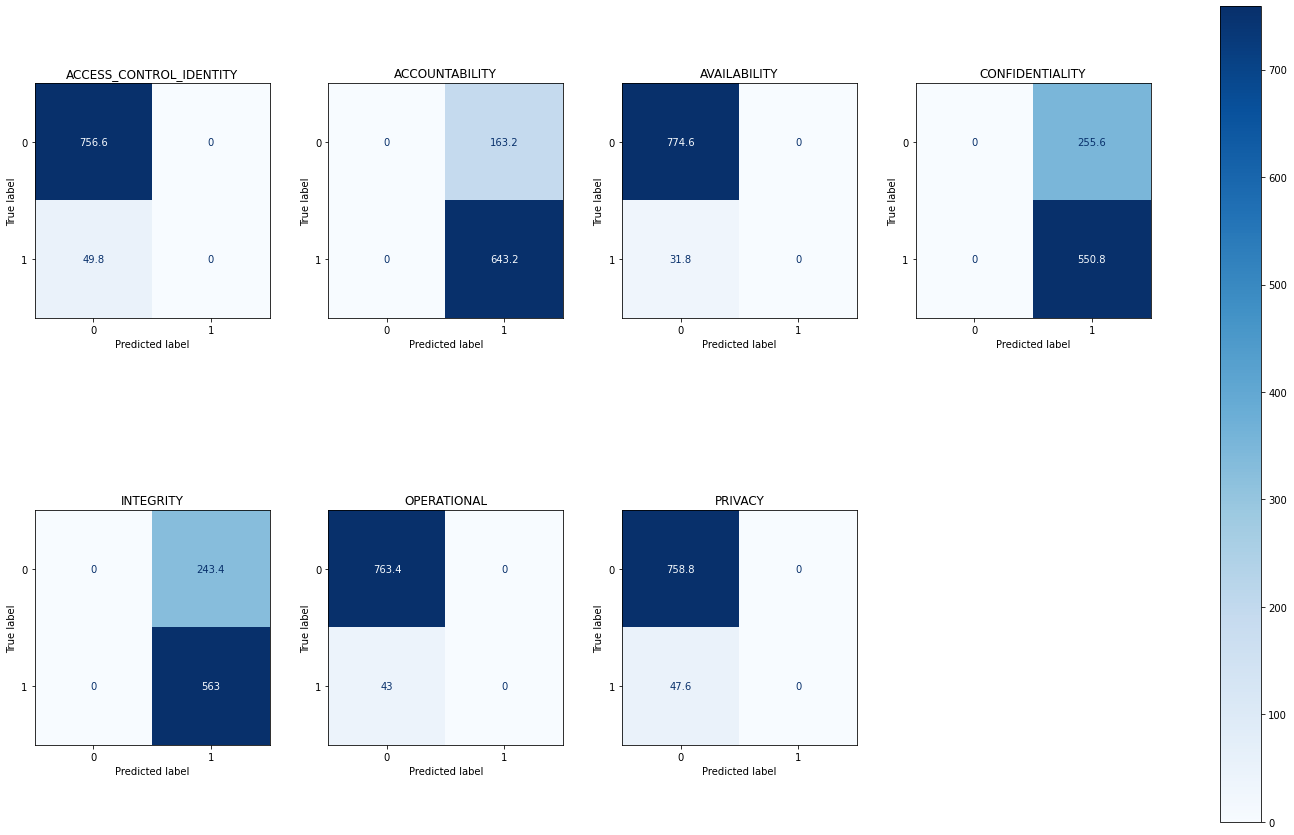

In [75]:
model = SVC(kernel='rbf', gamma=0.0001, C=10)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, BinaryRelevance, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

###**2.4.2) ClassifierChain**

####2.4.2.1) RandomForest

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7275136445678477
Precision: 0.7721854577494334
Recall Score: 0.8980949962371853
F1 Score: 0.8303732313014066
Hamming Loss: 0.12538981185101825


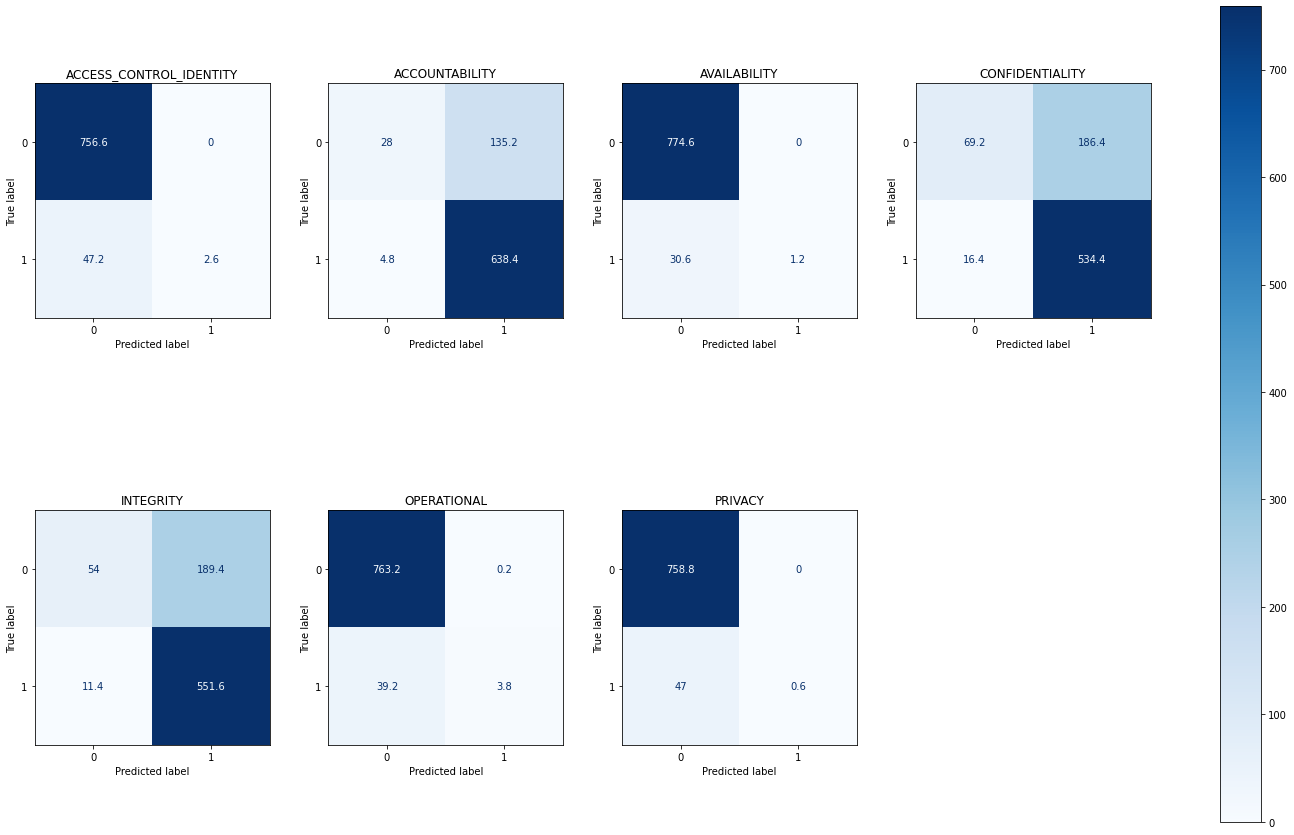

In [76]:
model = RandomForestClassifier(n_estimators=17, min_samples_split=6, min_samples_leaf=4, max_features='sqrt', max_depth=100, bootstrap=False)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, ClassifierChain, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.2.2) LogisticRegression

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7384247275954914
Precision: 0.7806468201101875
Recall Score: 0.8997042462920245
F1 Score: 0.8358774404018987
Hamming Loss: 0.12071299208845676


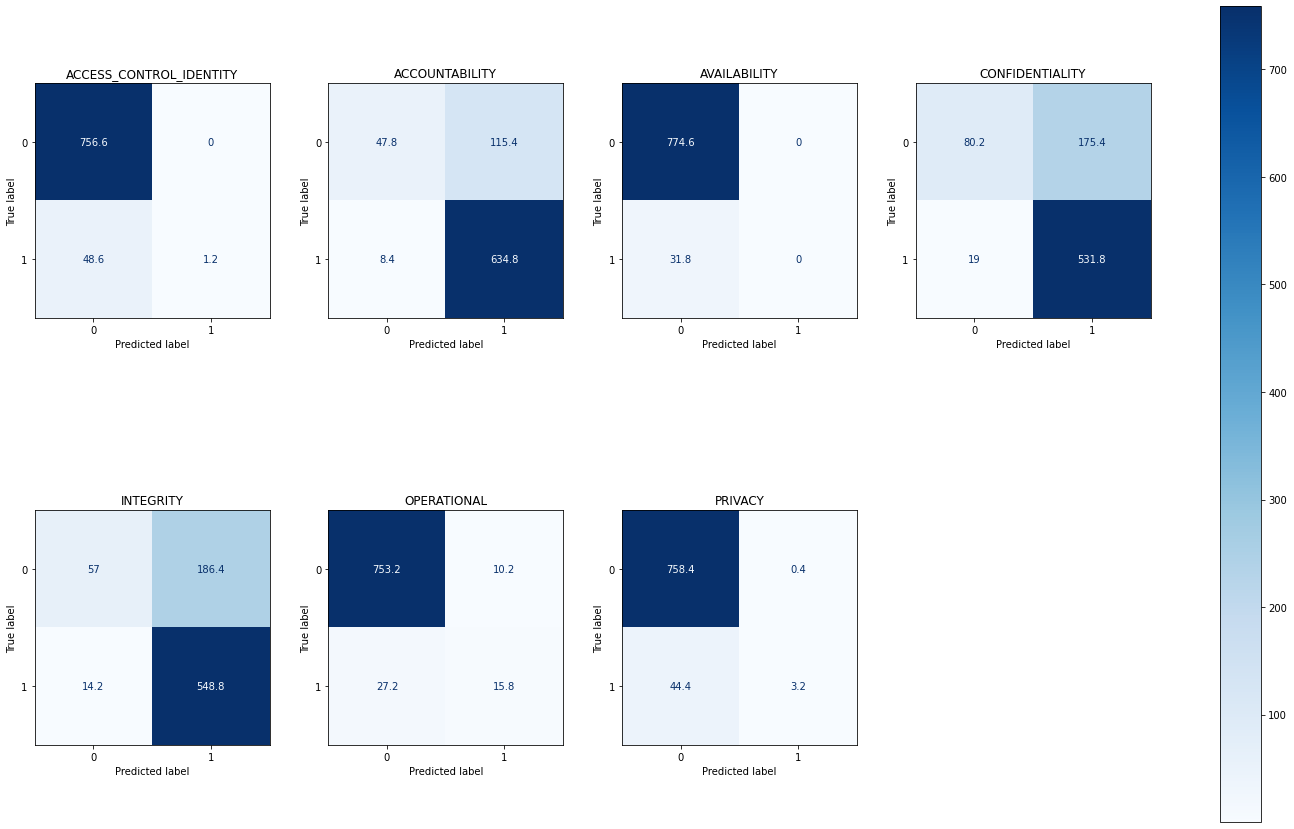

In [77]:
model = LogisticRegression(solver='saga', penalty='l2', max_iter=100, C=1)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, ClassifierChain, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.2.3) Gaussian Naive Bayes

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7053323381126475
Precision: 0.7295029775187507
Recall Score: 0.9083521914583417
F1 Score: 0.8091463321485604
Hamming Loss: 0.14643567648724143


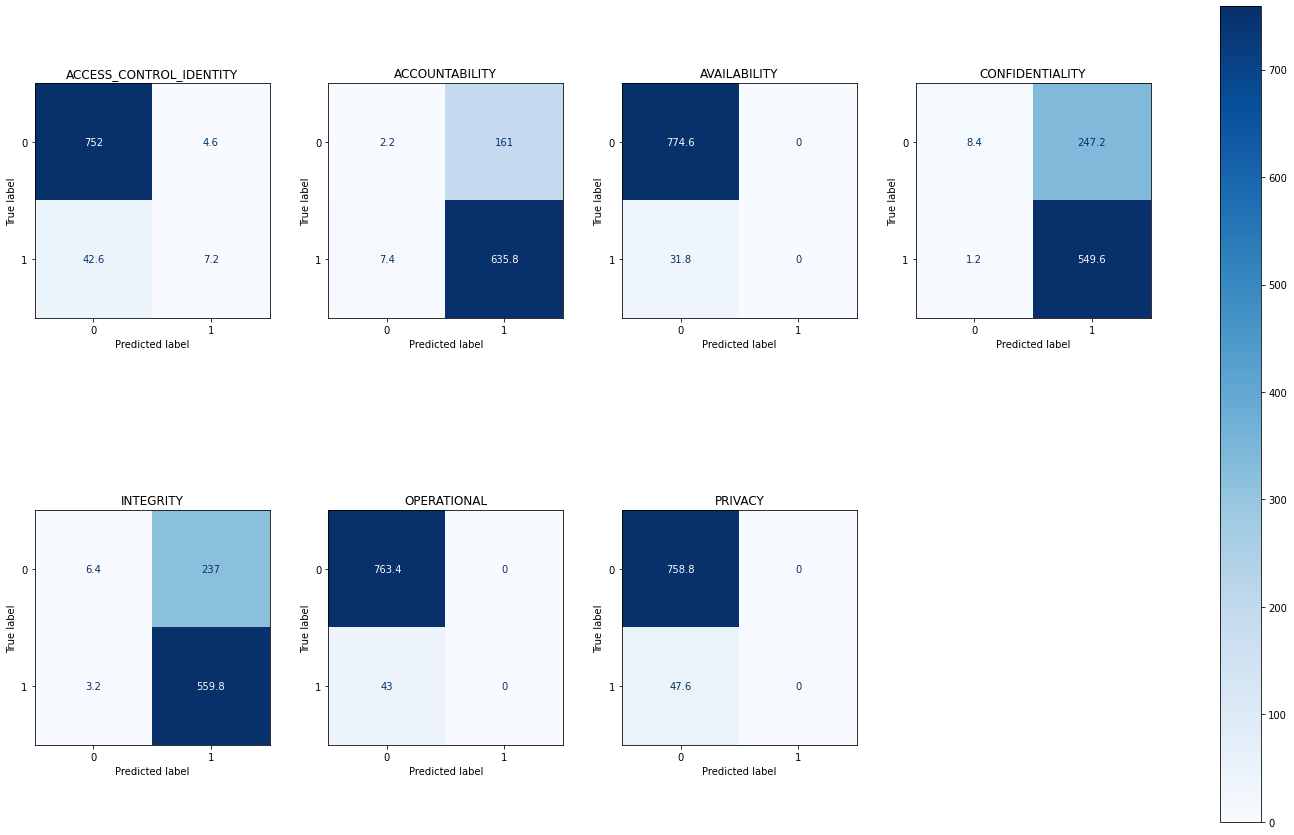

In [78]:
model = GaussianNB(var_smoothing=1.0)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, ClassifierChain, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.2.4) k-NearestNeighbors

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7444874152243142
Precision: 0.8208025821348235
Recall Score: 0.8476937033259194
F1 Score: 0.8339524901804211
Hamming Loss: 0.11536401400893545


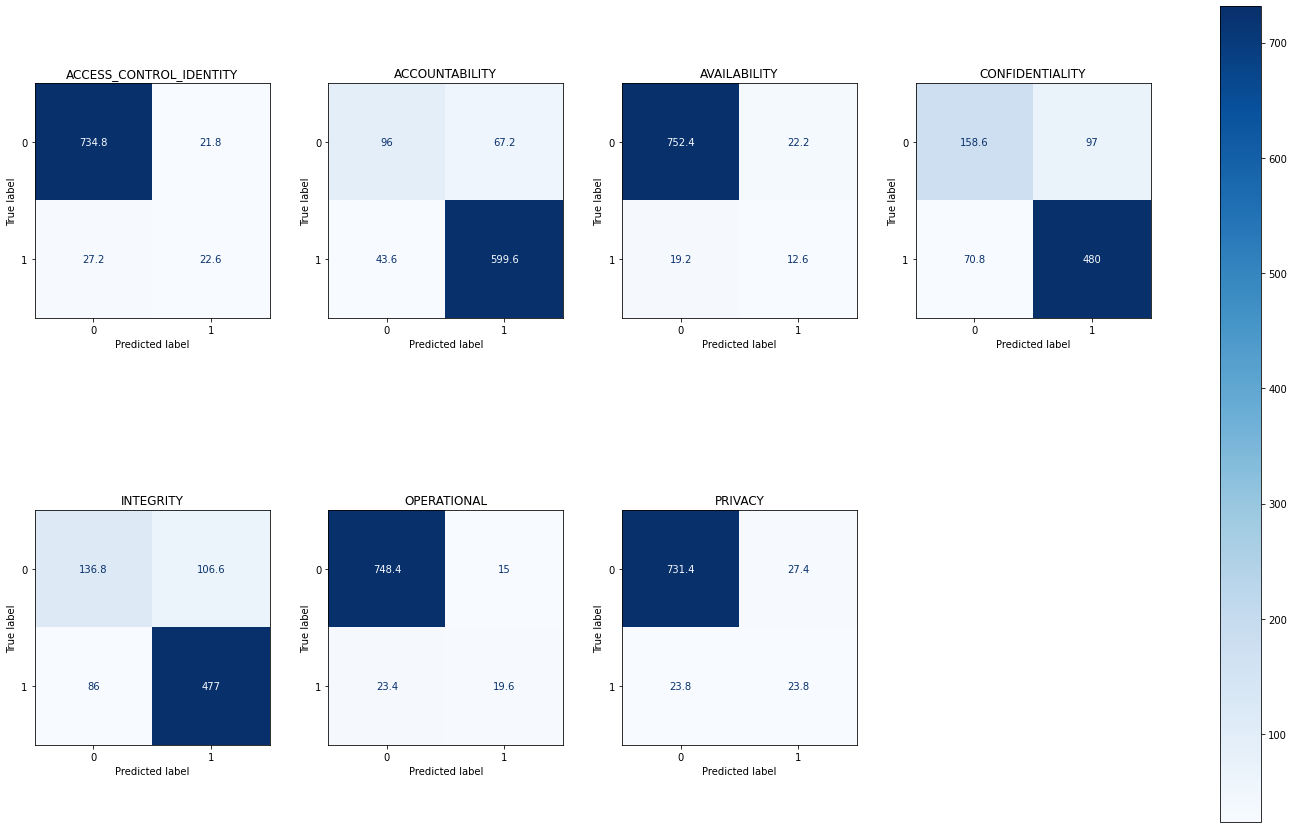

In [25]:
model = KNeighborsClassifier(algorithm='auto', weights='distance', p=2, n_neighbors=1, metric='minkowski', leaf_size=1)

ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, ClassifierChain, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.2.5) Decision Tree

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7014665463382336
Precision: 0.7303981892440178
Recall Score: 0.9021979411487797
F1 Score: 0.8072448762175221
Hamming Loss: 0.14721224732017393


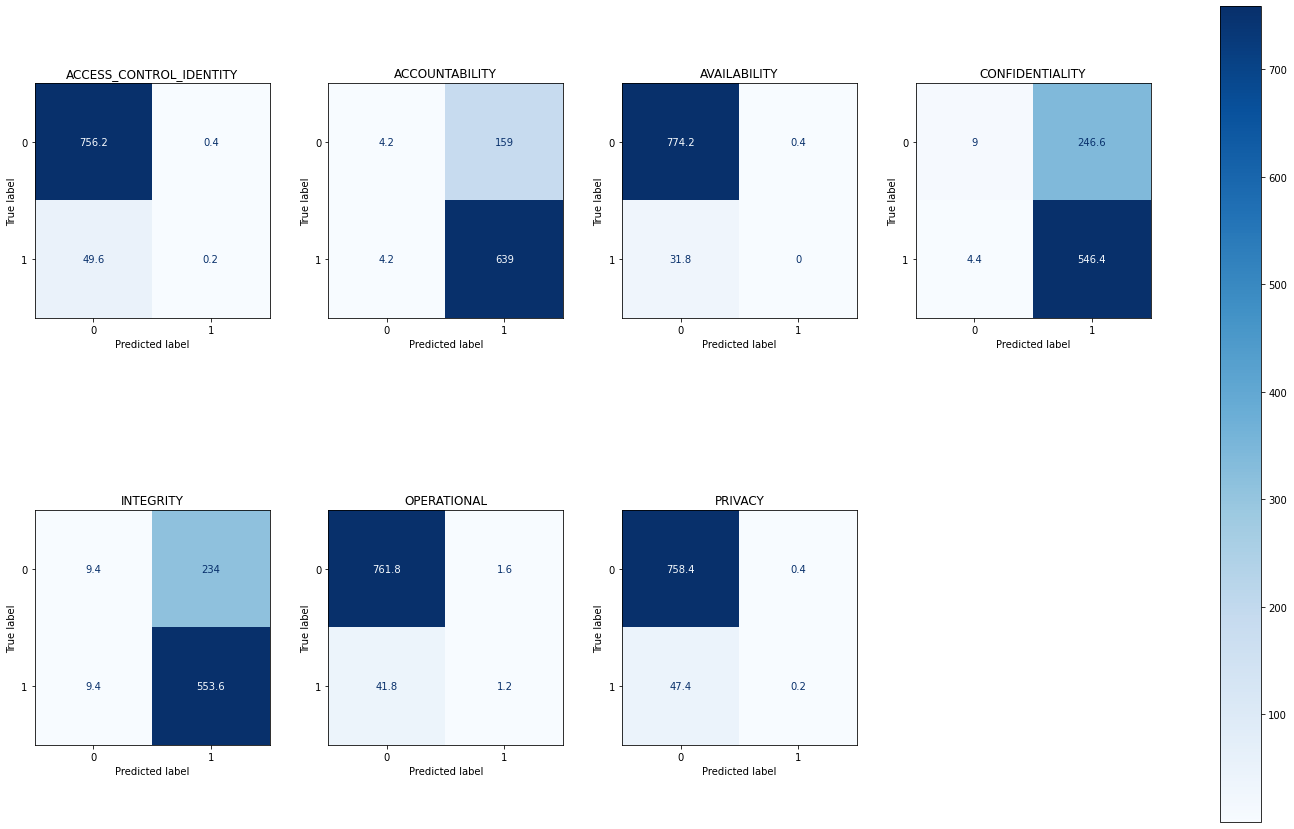

In [26]:
model = DecisionTreeClassifier(max_features='log2', max_depth=8, criterion='entropy', ccp_alpha=0.001)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, ClassifierChain, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.2.6) Support Vector Machine

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7054179926880491
Precision: 0.7262734161283148
Recall Score: 0.9107112775885218
F1 Score: 0.808067506021073
Hamming Loss: 0.1478187799329423


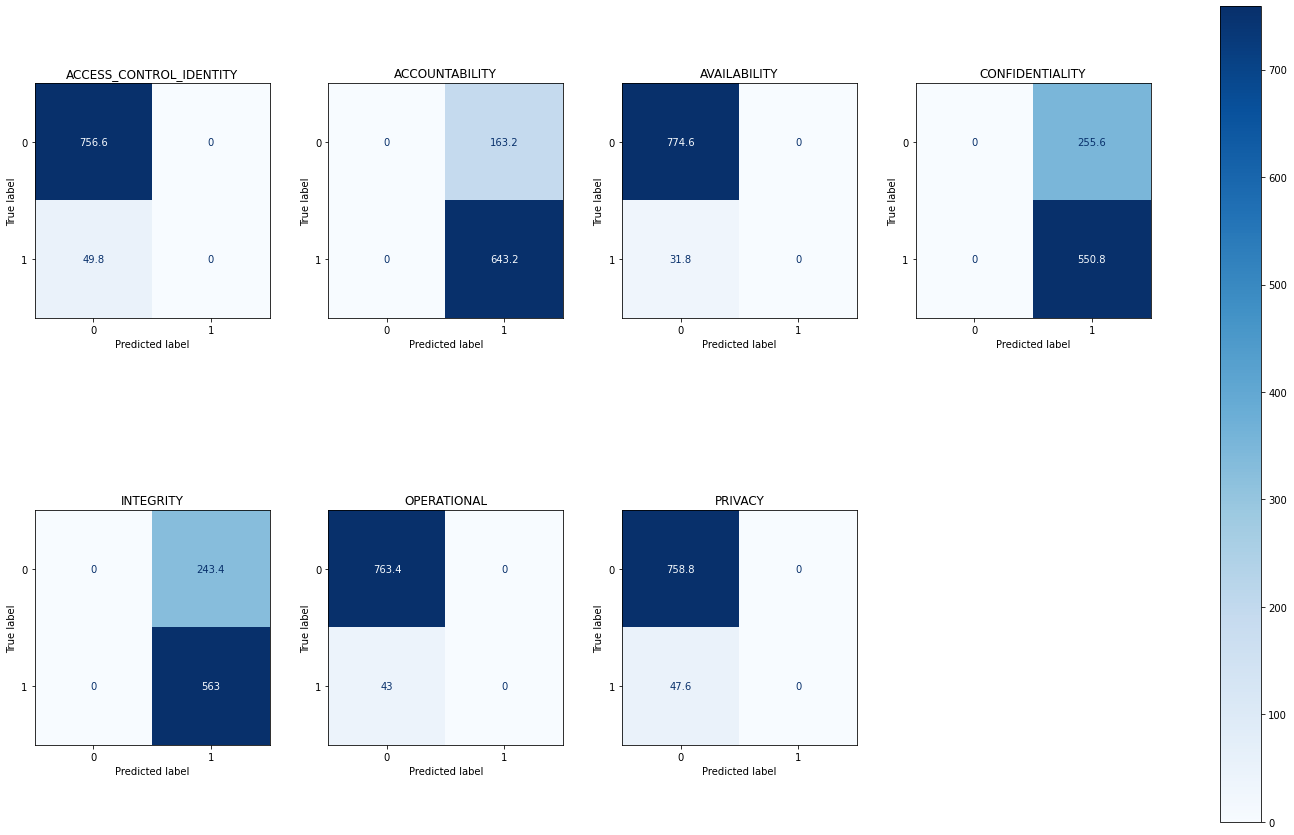

In [27]:
model = SVC(kernel='rbf', gamma=0.0001, C=10)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, ClassifierChain, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

###**2.4.3) LabelPowerset**

####2.4.3.1) RandomForest

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7331194633802861
Precision: 0.7560949165300501
Recall Score: 0.9107181176895631
F1 Score: 0.8262216220255951
Hamming Loss: 0.13091849190901836


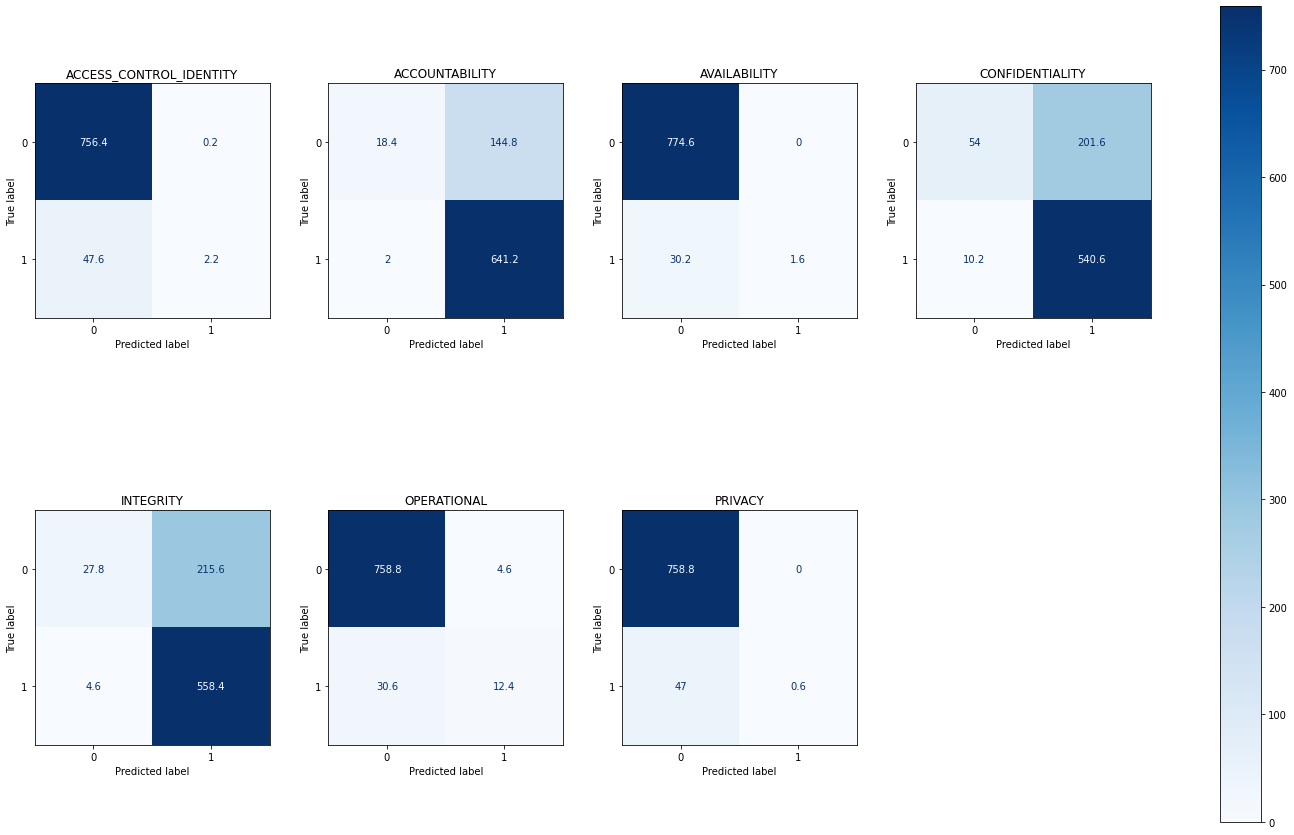

In [28]:
model = RandomForestClassifier(n_estimators=17, min_samples_split=6, min_samples_leaf=4, max_features='sqrt', max_depth=100, bootstrap=False)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, LabelPowerset, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.3.2) LogisticRegression

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7428057485012755
Precision: 0.7742936666371033
Recall Score: 0.901630517490824
F1 Score: 0.8330778727871591
Hamming Loss: 0.12340658901397598


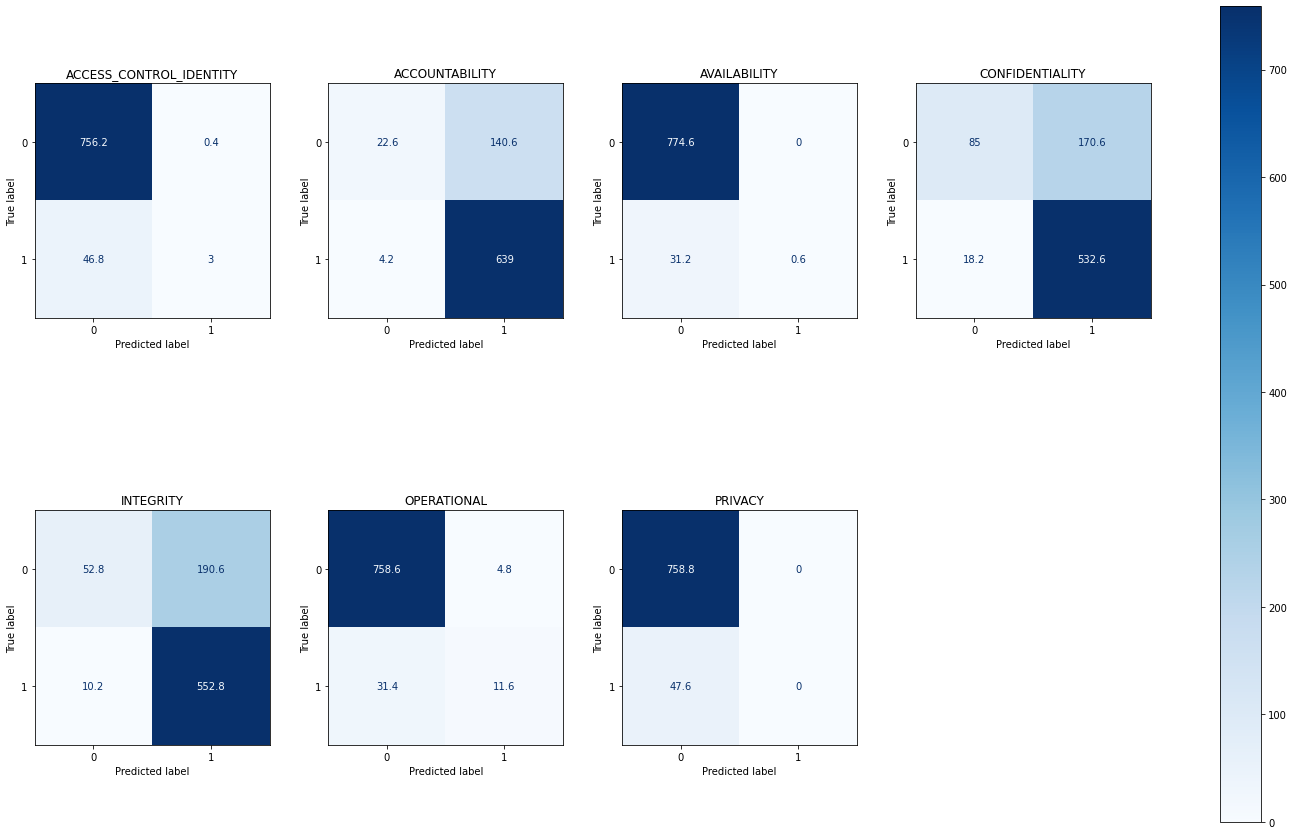

In [29]:
model = LogisticRegression(solver='saga', penalty='l2', max_iter=100, C=1)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, LabelPowerset, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.3.3) Gaussian Naive Bayes

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7048009661122745
Precision: 0.7287177443764791
Recall Score: 0.9079209309873113
F1 Score: 0.8084957563129658
Hamming Loss: 0.14696577755697554


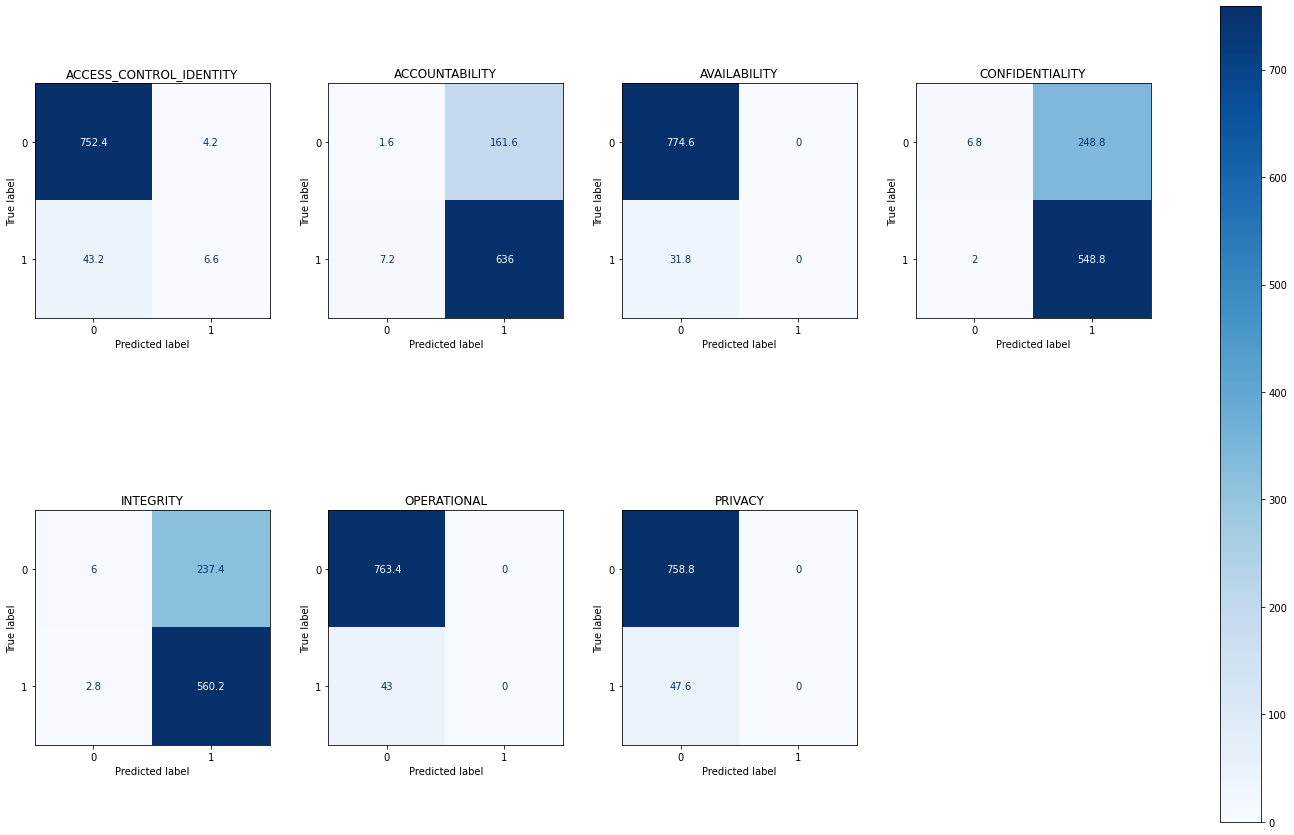

In [30]:
model = GaussianNB(var_smoothing=1.0)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, ClassifierChain, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.3.4) k-NearestNeighbors

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7351147578620896
Precision: 0.797826226579539
Recall Score: 0.8634507524189662
F1 Score: 0.8292745049088424
Hamming Loss: 0.12149250597505783


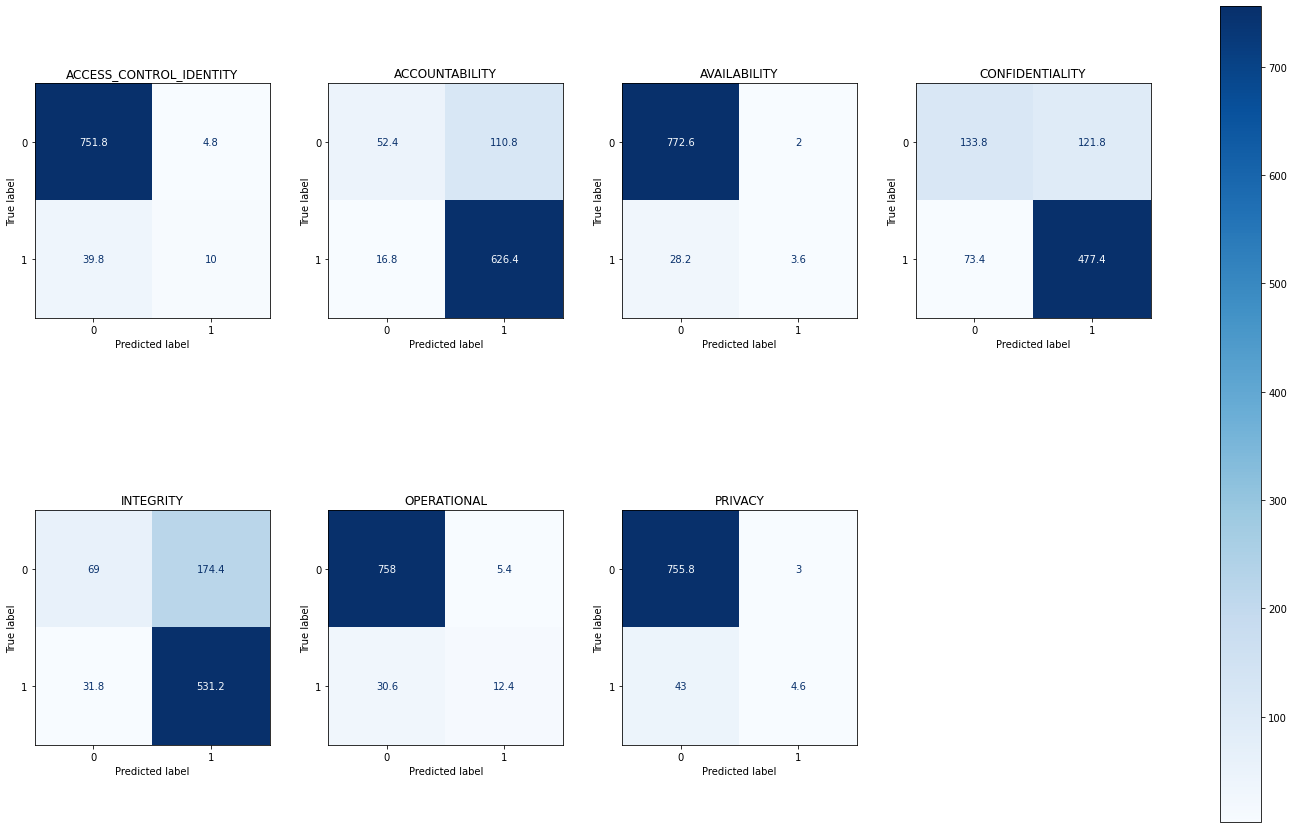

In [31]:
model = KNeighborsClassifier(algorithm='auto', weights='distance', p=1, n_neighbors=10, metric='minkowski', leaf_size=40)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, LabelPowerset, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.3.5) Decision Tree

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.705847638990102
Precision: 0.7305650490089485
Recall Score: 0.9057048949735904
F1 Score: 0.8087417453208007
Hamming Loss: 0.1463670198770331


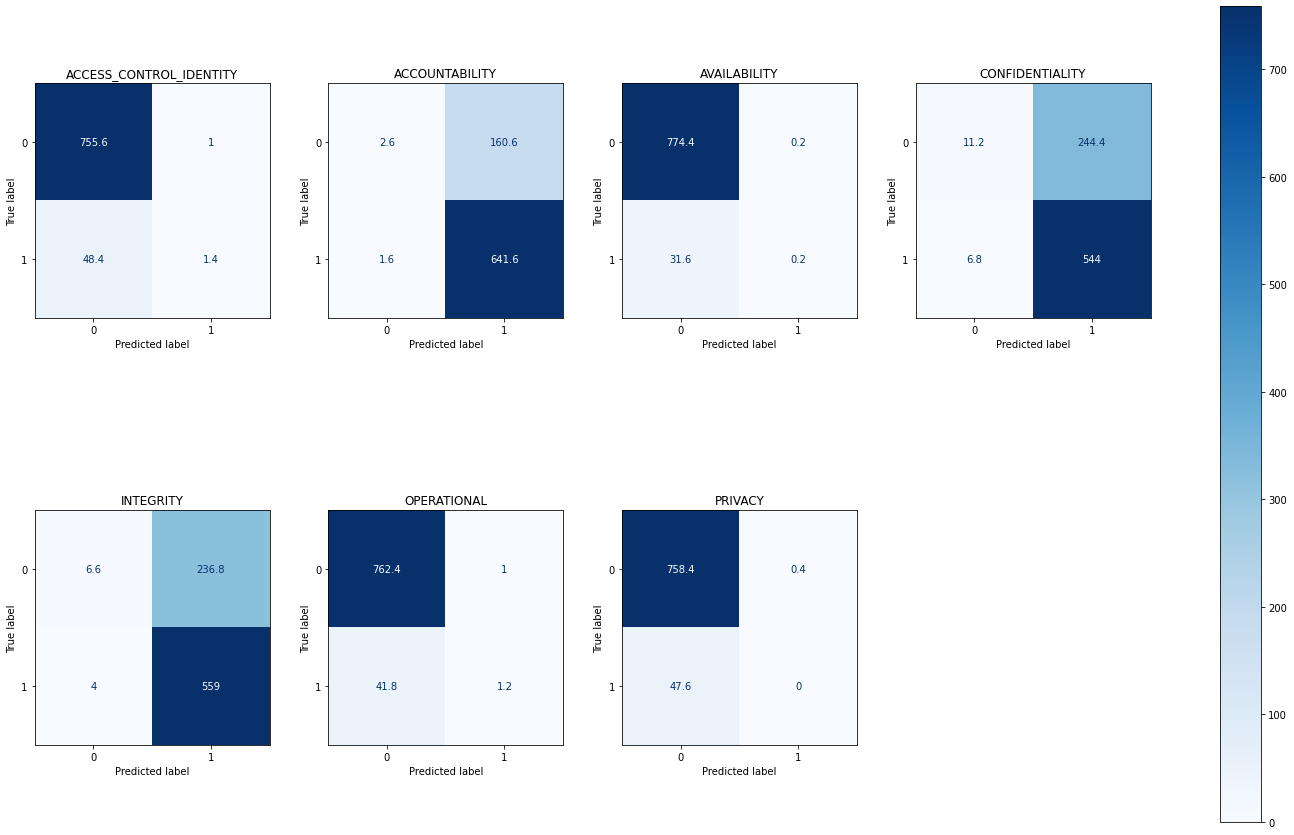

In [32]:
model = DecisionTreeClassifier(max_features='log2', max_depth=8, criterion='entropy', ccp_alpha=0.001)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, LabelPowerset, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.3.6) Support Vector Machine

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7054203449346753
Precision: 0.7262733136339085
Recall Score: 0.9106737792468413
F1 Score: 0.8080503797588869
Hamming Loss: 0.14781667147658273


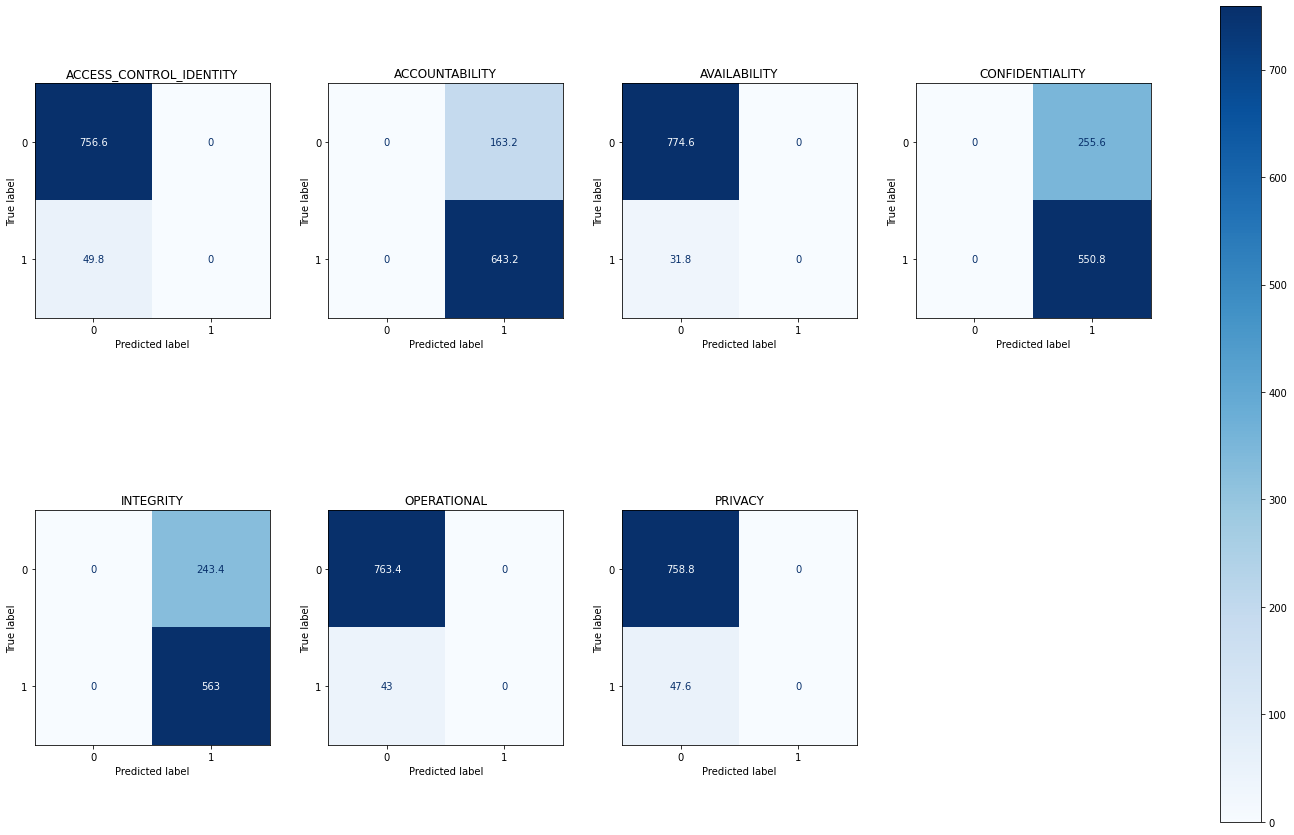

In [33]:
model = SVC(kernel='rbf', gamma=0.0001, C=10)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, LabelPowerset, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

In [34]:
bow = ""
for lists in cat_df["Security Words"]:
  if lists != 'none':
    lists = ast.literal_eval(lists)
    for words in lists:
        bow += words + " "

bow

'access access access client privacy access internet share privacy access data custodian access privacy access data custodian access access risk data integrity access access access access user access access response safety share client access access access access set set set set set capability access subject response set access access access access access access access information sharing safety access user interoperability set alert consequence authentication signature interoperability identity identity identity set user identity identity identity identity interoperability interoperability authentication authenticate alert privacy authorization authorization sensitive information privacy authorization authorization event authorization user user response response protocol interoperability protocol user set set set identity filter filter filter filter user user authenticate event identity filter response user event signature access access user access response alert access response regis

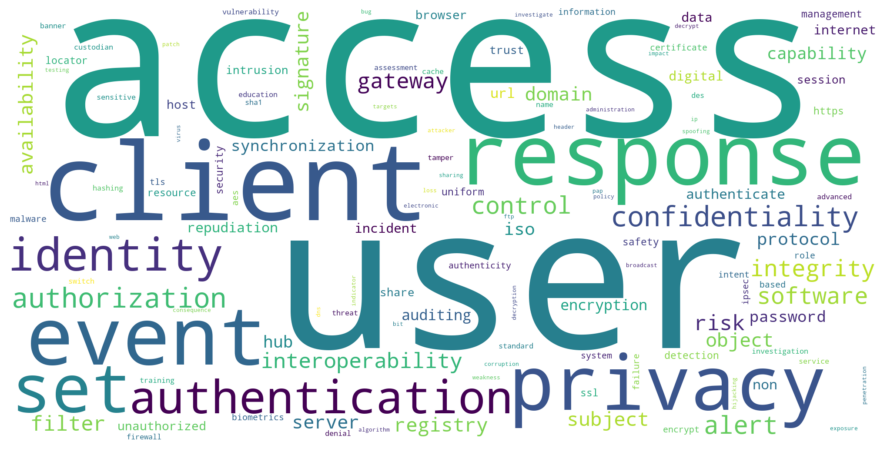

In [35]:
from wordcloud import WordCloud

wordcloud = WordCloud(width = 2000, height = 1000, collocations=False, background_color="white").generate(bow)

plt.figure(figsize=(32,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()